### Notebook to run association analyses for ABCD sample.
- Author: Dominik Kraft

- make sure to use correct conda environment or use __conda activate net_fusion__ before starting the jupyter notebook

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
pd.options.mode.chained_assignment = None 


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

## Note: 0 = female, 1 = male

In [4]:
##  seaborn settings 
sns.set_theme(
    context='paper',
    style='ticks',
    palette='dark',
    font='helvetica',
    font_scale=1,
    color_codes=True,
    rc=None,
)

In [5]:
dic = np.load('../embedding_scripts/outputs/outputdict_base_followup.npy',allow_pickle='TRUE').item()
## loading output of main_abcd.py

## baseline

In [6]:
baseline = dic["demos"][0]
baseline["prediction"] = np.squeeze(dic["predictions"][0]) # predicted embedding
baseline["sex"].replace({"F":0, "M":1}, inplace=True)

## follow up, 2y

In [7]:
follow = dic["demos"][1]
follow["prediction"] = np.squeeze(dic["predictions"][1])
follow["sex"].replace({"F":0, "M":1}, inplace=True)

follow.columns = follow.columns.map(lambda x : x+'_2y' if x !="subjectkey" else x)

#### combining both dfs + calc difference (delta_emb + delta_age)

In [8]:
embeddings = pd.merge(baseline, follow, on="subjectkey")

In [9]:
embeddings["diff_pred"] = np.diff(np.array(embeddings[["prediction","prediction_2y"]]))
embeddings["age_diff"] = np.diff(np.array(embeddings[["interview_age", "interview_age_2y"]]))

------

# Associations Analyses

### get puberty information and calculate pubertal categories

- returns list with 3 entries for timepoints: base, 1y, 2y
- c = caregiver | y = youth

#### define functions 

In [10]:
def female_categorical(row, care_or_youth):
    '''
    female: body hair growth + breast development || using menarche info as follows:
    prepubertal = 2 + no menarche
    early pubertal = 3 + no menarche
    midpubertal =>3 + no menarche
    late pubertal <=7 + menarche
    postpubertal = 8 + menarche
    according to Herting et al (2021) Frontiers in Endocrinology
    '''
    ### based on caregiver or youth report, menarche variable is labeled differently
    if care_or_youth == "youth":
        menarche = row["pds_f5_y"]
    elif care_or_youth == "caregiver":
        menarche = row["pds_f5b_p"]
    
    if np.isnan(row["PDS_cat_score"])==False:    
        if menarche == 1.0:
            if row["PDS_cat_score"] == 2.0:
                return "prepubertal"
            if row["PDS_cat_score"] == 3.0:
                return "early pubertal"
            if row["PDS_cat_score"] >= 3.0:
                return "midpubertal"
            
        elif menarche == 4.0:
            if row["PDS_cat_score"] <= 7.0:
                return "late pubertal"
            if row["PDS_cat_score"] == 8.0:
                return "postpubertal"
                     
    elif np.isnan(row["PDS_cat_score"])==True:
        return np.nan
    

def male_categorical(row):
    '''
    male: body hair growth + facial hair + voice change
    prepubertal = 3 x
    early pubertal = 4 or 5 (no 3 point response)x
    midpubertal = 6-8 (no point 4 response) x
    late pubertal = 9-11 
    postpubertal = 12 (all 4 point)
    according to Herting et al (2021) Frontiers in Endocrinology
    with minor adjustment to not create cases for which category is not
    well defined (see paper)
    '''
    
    if np.isnan(row["PDS_cat_score"])==False:
        if row["PDS_cat_score"] == 3.0:
            return "prepubertal"
        
        if 4.0 <= row["PDS_cat_score"] <= 5.0:
            return "early pubertal"

        if 6.0 <= row["PDS_cat_score"] <= 8.0:
            return "midpubertal"
   
        if 9.0 <= row["PDS_cat_score"] <= 11.0:
                return "late pubertal"
            
        if row["PDS_cat_score"] == 12.0:
            return "postpubertal"
        
    elif np.isnan(row["PDS_cat_score"])==True:
        return np.nan

In [11]:
def calc_pubertal_scores(timepoint, care_or_youth):
    
    ''''
    This function calculates 'summary' scores derived from the PDS Scale:
    - gonadal vs adrenal processes
    - mean PDS
    - PDS categorical score + pubertal stage 
    -----
    Input:
    - file: ABCD file containing information about perceived puberty without .txt extension. Default: caregiver report
    - timepoint: (str) from ['1_year_follow_up_y_arm_1', 'baseline_year_1_arm_1','2_year_follow_up_y_arm_1']
    -----
    Output:
    - dataframe: file + 'summary' pubertal scores
    '''
        
    # who replied? 
    if care_or_youth == "caregiver":
        file = "abcd_ppdms01"
    elif care_or_youth =="youth":
        file = "abcd_ypdms01"
        
    
    ## load file 
    path = "../network_fusion/Package_1197473/{}.txt"
    f = path.format(file)
    
    header = pd.read_csv(f, header=None, sep='\t', nrows=2)
    df = pd.read_csv(f, header=None, sep='\t', skiprows=2)
    df.columns = list(header.iloc[0, :])
    
    df = df.drop_duplicates(
        subset=["subjectkey", "interview_date", "interview_age"], ignore_index=False)
    
    df_t = df.loc[df["eventname"]==timepoint] ## choose timepoint
    df_t.replace(999.0, np.nan, inplace=True) ## replace all "dont know" with np.nan
    df_t.replace(777.0, np.nan, inplace=True) ## replace all "refuse to answer" with np.nan -- only for youth
    
    
    fem = df_t.loc[df_t.sex=="F"] ## subset for sex
    men = df_t.loc[df_t.sex=="M"]
    
    ## calculate puberty scores based on youth report
    if care_or_youth == "youth":
    
        ## calculate gonadal puberty scores 
        fem["gonadal"]= fem[["pds_ht2_y", "pds_f4_2_y", "pds_f5_y"]].mean(axis=1, skipna=False)
        men["gonadal"] = men[["pds_ht2_y","pds_m4_y", "pds_m5_y"]].mean(axis=1, skipna=False)

        ## calculate adrenal puberty scores
        fem["adrenal"]= fem[["pds_skin2_y", "pds_bdyhair_y"]].mean(axis=1, skipna=False)
        men["adrenal"]= men[["pds_skin2_y", "pds_bdyhair_y"]].mean(axis=1, skipna=False)

        ## calculate average PDS scores
        fem["PDS_mean"] =  fem[["pds_ht2_y", "pds_f4_2_y", "pds_f5_y", 
                                "pds_skin2_y", "pds_bdyhair_y"]].mean(axis=1, skipna=False)
        men["PDS_mean"] =  men[["pds_ht2_y","pds_m4_y", "pds_m5_y",
                                "pds_skin2_y", "pds_bdyhair_y"]].mean(axis=1, skipna=False)

        ## calculate PDS category score
        fem["PDS_cat_score"] = fem[["pds_f4_2_y", "pds_bdyhair_y"]].sum(axis=1, skipna=False)
        men["PDS_cat_score"] = men[["pds_bdyhair_y", "pds_m5_y", "pds_m4_y"]].sum(axis=1, skipna=False)

        ## transform PDS category scores to pubertal stages
        fem["PDS_category"] = fem.apply(lambda row: female_categorical(row, care_or_youth="youth"), axis=1)
        men["PDS_category"] = men.apply(lambda row: male_categorical(row), axis=1)
        
    
    ## calculate puberty scores based on caregiver report
    elif care_or_youth =="caregiver":
        
        ## calculate gonadal puberty scores 
        fem["gonadal"]= fem[["pds_1_p", "pds_f4_p", "pds_f5b_p"]].mean(axis=1, skipna=False)
        men["gonadal"] = men[["pds_1_p","pds_m4_p", "pds_m5_p"]].mean(axis=1, skipna=False)

        ## calculate adrenal puberty scores
        fem["adrenal"]= fem[["pds_3_p", "pds_2_p"]].mean(axis=1, skipna=False)
        men["adrenal"]= men[["pds_3_p", "pds_2_p"]].mean(axis=1, skipna=False)

        ## calculate average PDS scores
        fem["PDS_mean"] =  fem[["pds_1_p", "pds_f4_p", "pds_f5b_p", "pds_3_p", "pds_2_p"]].mean(axis=1, skipna=False)
        men["PDS_mean"] =  men[["pds_1_p","pds_m4_p", "pds_m5_p", "pds_3_p", "pds_2_p"]].mean(axis=1, skipna=False)

        ## calculate PDS category score
        fem["PDS_cat_score"] = fem[["pds_f4_p", "pds_2_p"]].sum(axis=1, skipna=False)
        men["PDS_cat_score"] = men[["pds_2_p", "pds_m5_p", "pds_m4_p"]].sum(axis=1, skipna=False)

        ## transform PDS category scores to pubertal stages
        fem["PDS_category"] = fem.apply(lambda row: female_categorical(row, care_or_youth="caregiver"), axis=1)
        men["PDS_category"] = men.apply(lambda row: male_categorical(row), axis=1)
        
    ## combine both datasets and return 
    return pd.concat([fem, men])

In [12]:
puberty_df_c = [] #caregiver
puberty_df_y = [] #youth

timepoints= ['baseline_year_1_arm_1','1_year_follow_up_y_arm_1',
                  '2_year_follow_up_y_arm_1']

for t in timepoints:
    
    df = calc_pubertal_scores(timepoint=t, care_or_youth="caregiver")
    puberty_df_c.append(df)
    
    
puberty_df_y = []

for t in timepoints:
    df = calc_pubertal_scores(timepoint=t, care_or_youth="youth")
    puberty_df_y.append(df) # could be also solved in single loop

/Users/Dominik/opt/anaconda3/envs/net_fusion/lib/python3.7/site-packages/ipykernel_launcher.py:16: DtypeWarning: Columns (0,1,2,35) have mixed types.Specify dtype option on import or set low_memory=False.
  app.launch_new_instance()


# cross sectional models

#### define functions


    
    


In [14]:
def partial_eta_square(model):
    """
    Function to calculate partial eta square from OLS model after fitting
    ---
    Input:
    - sm.model object after fitting the model
    ----
    Output:
    - no return value, but prints partial eta squares for each predictor in model
    """
    
    # transform model to anova table
    anova_table = sm.stats.anova_lm(model) 
    # index of anova table = predictor list
    predictors = anova_table.index.to_list()
    
    # exclude categorical predictors + residuals
    to_exclude = ("C(", "Resi")
    predictors = [p for p in predictors if not p.startswith(to_exclude)]
    
    #iterate over all predictors and calculate eta squared 
    for predictor in predictors:
        SS_predictor = anova_table.loc[predictor, 'sum_sq']
        SS_resid = anova_table.loc['Residual', 'sum_sq']
        partial_eta_squared = SS_predictor / (SS_predictor + SS_resid)
        print(f'Partial eta squared for {predictor}: {partial_eta_squared.round(5)}')

### Baseline models

In [15]:
## initiate empty lists to store results for caregiver and youth reports 

# caregiver results stratified for sex
fem_c=[]
male_c=[]

# youth results stratified for sex 
fem_y = []
male_y = []
# note: for vizualisation purposes, run the code in the following order: baseline, 2y, longitudinal

In [16]:
 #### caregiver baseline ### 

puberty_model_baseline = 'prediction ~ PDS_mean + interview_age+  C(mri_info_deviceserialnumber)'

for sex in range(2):
    
    if sex == 0:
        print("FEMALE")
    
    elif sex ==1:
        print("MALE")
    
    tmp = pd.merge(embeddings[["prediction", "subjectkey", "sex",
                                     "mri_info_deviceserialnumber", "interview_age"]], 
                puberty_df_c[0][["PDS_mean", "subjectkey"]], on="subjectkey")

    model = smf.ols(formula=puberty_model_baseline, data=tmp.loc[tmp["sex"]==sex]).fit()
    
    summary = model.summary()

    print(puberty_model_baseline)
    print(int(model.nobs)) #
    print(summary.tables[1])
    print(model.params[-2], model.pvalues[-2])
    print(model.params[-1], model.pvalues[-1])
    print("\n")
    
    # get partial eta squared for each predictor 
    partial_eta_square(model)
    
    print("\n\n")

    if sex == 0:
        fem_c.append(model.params[-2]) # store PDS coefficient in respective list 
    elif sex == 1:
        male_c.append(model.params[-2])

FEMALE
prediction ~ PDS_mean + interview_age+  C(mri_info_deviceserialnumber)
3344
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.2120      0.343      0.618      0.536      -0.460       0.884
C(mri_info_deviceserialnumber)[T.HASH11ad4ed5]    -0.2132      0.146     -1.459      0.145      -0.500       0.073
C(mri_info_deviceserialnumber)[T.HASH1314a204]    -0.3844      0.141     -2.720      0.007      -0.661      -0.107
C(mri_info_deviceserialnumber)[T.HASH311170b9]    -0.2188      0.152     -1.440      0.150      -0.517       0.079
C(mri_info_deviceserialnumber)[T.HASH31ce566d]     0.2670      0.308      0.867      0.386      -0.337       0.871
C(mri_info_deviceserialnumber)[T.HASH3935c89e]    -0.3266      0.129     -2.540      0.011      -0.579      -0.0

In [17]:
### youth baseline ### 

for sex in range(2):
    
    if sex == 0:
        print("FEMALE")
    
    elif sex ==1:
        print("MALE")
    
    tmp = pd.merge(embeddings[["prediction", "subjectkey", "sex",
                                     "mri_info_deviceserialnumber", "interview_age"]], 
                puberty_df_y[0][["PDS_mean", "subjectkey"]], on="subjectkey")

    model = smf.ols(formula=puberty_model_baseline, data=tmp.loc[tmp["sex"]==sex]).fit()
    
    summary = model.summary()

    print(puberty_model_baseline)
    print(int(model.nobs)) 
    print(summary.tables[1])
    print(model.params[-2], model.pvalues[-2])
    print(model.params[-1], model.pvalues[-1])
    print("\n")
    
    # get partial eta squared for each predictor 
    partial_eta_square(model)
    print("\n\n")
   
    if sex == 0:
        fem_y.append(model.params[-2]) # store PDS coefficient in respective list 
    elif sex == 1:
        male_y.append(model.params[-2])

FEMALE
prediction ~ PDS_mean + interview_age+  C(mri_info_deviceserialnumber)
1479
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.2833      0.514      0.551      0.582      -0.725       1.292
C(mri_info_deviceserialnumber)[T.HASH11ad4ed5]     0.1314      0.219      0.601      0.548      -0.297       0.560
C(mri_info_deviceserialnumber)[T.HASH1314a204]    -0.0624      0.203     -0.308      0.758      -0.460       0.336
C(mri_info_deviceserialnumber)[T.HASH311170b9]    -0.0990      0.224     -0.442      0.658      -0.538       0.340
C(mri_info_deviceserialnumber)[T.HASH31ce566d]     0.4401      0.492      0.895      0.371      -0.525       1.405
C(mri_info_deviceserialnumber)[T.HASH3935c89e]     0.1591      0.186      0.857      0.392      -0.205       0.5

### 2 year follow up models

In [18]:
 #### caregiver 2year ### 

puberty_model_2y = 'prediction_2y ~ PDS_mean + interview_age_2y+ C(mri_info_deviceserialnumber_2y)'

for sex in range(2):
    
    if sex == 0:
        print("FEMALE")
    
    elif sex ==1:
        print("MALE")
    
    tmp = pd.merge(embeddings[["prediction_2y", "subjectkey", "sex",
                                     "mri_info_deviceserialnumber_2y", "interview_age_2y"]], 
                puberty_df_c[2][["PDS_mean", "subjectkey"]], on="subjectkey")

 
    model = smf.ols(formula=puberty_model_2y, data=tmp.loc[tmp["sex"]==sex]).fit()
    
    summary = model.summary()

    print(puberty_model_2y)
    print(int(model.nobs)) 
    print(summary.tables[1])
    print(model.params[-2], model.pvalues[-2])
    print(model.params[-1], model.pvalues[-1])
    print("\n")
    # get partial eta squared for each predictor 
    partial_eta_square(model)
    print("\n\n")
 
    if sex == 0:
        fem_c.append(model.params[-2]) # store PDS coefficient in respective list 
    elif sex == 1:
        male_c.append(model.params[-2])

FEMALE
prediction_2y ~ PDS_mean + interview_age_2y+ C(mri_info_deviceserialnumber_2y)
3316
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.7288      0.566      1.287      0.198      -0.382       1.839
C(mri_info_deviceserialnumber_2y)[T.HASH03db707f]    -0.0741      0.425     -0.175      0.861      -0.907       0.758
C(mri_info_deviceserialnumber_2y)[T.HASH11ad4ed5]    -0.1626      0.421     -0.387      0.699      -0.987       0.662
C(mri_info_deviceserialnumber_2y)[T.HASH1314a204]    -0.3290      0.419     -0.785      0.433      -1.151       0.493
C(mri_info_deviceserialnumber_2y)[T.HASH311170b9]    -0.2304      0.423     -0.544      0.586      -1.060       0.599
C(mri_info_deviceserialnumber_2y)[T.HASH31ce566d]     0.1515      0.916      0.165 

In [19]:
 #### youth 2year ### 
for sex in range(2):
    
    if sex == 0:
        print("FEMALE")
    
    elif sex ==1:
        print("MALE")
    
    tmp = pd.merge(embeddings[["prediction_2y", "subjectkey", "sex",
                                     "mri_info_deviceserialnumber_2y", "interview_age_2y"]], 
                puberty_df_y[2][["PDS_mean", "subjectkey"]], on="subjectkey")
    
    model = smf.ols(formula=puberty_model_2y, data=tmp.loc[tmp["sex"]==sex]).fit()
    
    summary = model.summary()
   
    print(puberty_model_2y)
    print(int(model.nobs)) 
    print(summary.tables[1])
    print(model.params[-2], model.pvalues[-2])
    print(model.params[-1], model.pvalues[-1])
    print("\n")  
    # get partial eta squared for each predictor 
    partial_eta_square(model)
    print("\n\n")
   
    if sex == 0:
        fem_y.append(model.params[-2]) # store PDS coefficient in respective list 
    elif sex == 1:
        male_y.append(model.params[-2]) 

FEMALE
prediction_2y ~ PDS_mean + interview_age_2y+ C(mri_info_deviceserialnumber_2y)
3271
                                                        coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                             0.3724      0.569      0.654      0.513      -0.743       1.488
C(mri_info_deviceserialnumber_2y)[T.HASH03db707f]     0.1195      0.423      0.282      0.778      -0.711       0.950
C(mri_info_deviceserialnumber_2y)[T.HASH11ad4ed5]     0.0810      0.421      0.193      0.847      -0.744       0.906
C(mri_info_deviceserialnumber_2y)[T.HASH1314a204]    -0.0572      0.419     -0.137      0.891      -0.879       0.764
C(mri_info_deviceserialnumber_2y)[T.HASH311170b9]     0.0263      0.423      0.062      0.950      -0.803       0.856
C(mri_info_deviceserialnumber_2y)[T.HASH31ce566d]     0.5323      0.916      0.581 

# longitudinal models

### delta embedding - delta PDS

In [20]:
def get_delta_PDS(report):
    
    ''' Function to calculate delta_PDS score, i.e. difference between baseline
    and 2 year follow up PDS_mean score
    Input:
    - report: caregiver or youth (str)
    Output:
    - dataframe containing baseline, 2year, and delta embedding 
    '''
    
    if report == "caregiver":
        df_list = puberty_df_c
    elif report =="youth":
        df_list = puberty_df_y
        
    # get baseline and follow up data from list     
    base = df_list[0][['PDS_mean',"subjectkey", "sex"]].copy()
    follow = df_list[2][['PDS_mean',"subjectkey"]].copy()
    
    # rename PDS follow up columns for merging
    follow.columns = follow.columns.map(lambda x : x+'_2y' if x !="subjectkey" else x)
    
    # merge both dataframes
    merged = pd.merge(base, follow, on="subjectkey")
    
    # calculate difference between PDS_mean scores
    merged["PDS_mean_diff"] = np.diff(np.array(merged[["PDS_mean","PDS_mean_2y"]]))
    
    return merged

In [21]:
delta_model = 'diff_pred ~ PDS_mean_diff + age_diff + C(mri_info_deviceserialnumber)'

for rep in ["caregiver", "youth"]:
    print(rep)
    
    pub_diff = get_delta_PDS(report=rep)

    for sex in range(2):

        if sex == 0:
            print("FEMALE")

        elif sex ==1:
            print("MALE")

        tmp = pd.merge(embeddings[["diff_pred", "subjectkey", "sex",
                                         "mri_info_deviceserialnumber", "age_diff"]], 
                    pub_diff[["PDS_mean_diff", "subjectkey"]], on="subjectkey")

        model = smf.ols(formula=delta_model, data=tmp.loc[tmp["sex"]==sex]).fit()

        summary = model.summary()

        print(delta_model)
        print(int(model.nobs)) 
        print(summary.tables[1])
        print(model.params[-2], model.pvalues[-2])
        print(model.params[-1], model.pvalues[-1])
        print("\n")
        # get partial eta squared for each predictor 
        partial_eta_square(model)
        print("\n", "\n")
        
        ## store coefficients for plotting 
        if rep == "caregiver":
            if sex == 0:
                fem_c.append(model.params[-2])
            elif sex == 1:
                male_c.append(model.params[-2])
        elif rep == "youth":
            if sex == 0:
                fem_y.append(model.params[-2])
            elif sex == 1:
                male_y.append(model.params[-2])

caregiver
FEMALE
diff_pred ~ PDS_mean_diff + age_diff + C(mri_info_deviceserialnumber)
3135
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.1766      0.065      2.716      0.007       0.049       0.304
C(mri_info_deviceserialnumber)[T.HASH11ad4ed5]     0.0403      0.035      1.155      0.248      -0.028       0.109
C(mri_info_deviceserialnumber)[T.HASH1314a204]     0.0070      0.034      0.206      0.837      -0.060       0.074
C(mri_info_deviceserialnumber)[T.HASH311170b9]    -0.0274      0.037     -0.744      0.457      -0.100       0.045
C(mri_info_deviceserialnumber)[T.HASH31ce566d]     0.8184      0.076     10.746      0.000       0.669       0.968
C(mri_info_deviceserialnumber)[T.HASH3935c89e]     0.0413      0.031      1.329      0.184      -0.020 

diff_pred ~ PDS_mean_diff + age_diff + C(mri_info_deviceserialnumber)
1375
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.0810      0.098      0.824      0.410      -0.112       0.274
C(mri_info_deviceserialnumber)[T.HASH11ad4ed5]     0.0739      0.053      1.387      0.166      -0.031       0.178
C(mri_info_deviceserialnumber)[T.HASH1314a204]     0.0312      0.049      0.636      0.525      -0.065       0.127
C(mri_info_deviceserialnumber)[T.HASH311170b9]     0.0162      0.055      0.294      0.769      -0.092       0.124
C(mri_info_deviceserialnumber)[T.HASH31ce566d]     0.7534      0.128      5.890      0.000       0.502       1.004
C(mri_info_deviceserialnumber)[T.HASH3935c89e]     0.0444      0.045      0.985      0.325      -0.044       0.133
C(mri

In [22]:
### controlling for baseline puberty scores

delta_model_corrected = 'diff_pred ~ PDS_mean_diff + PDS_mean + age_diff + C(mri_info_deviceserialnumber)'

for rep in ["caregiver", "youth"]:
    print(rep)
    
    pub_diff = get_delta_PDS(report=rep)

    for sex in range(2):

        if sex == 0:
            print("FEMALE")

        elif sex ==1:
            print("MALE")

        tmp = pd.merge(embeddings[["diff_pred", "subjectkey", "sex",
                                         "mri_info_deviceserialnumber", "age_diff"]], 
                    pub_diff[["PDS_mean_diff","PDS_mean", "subjectkey"]], on="subjectkey")

        model = smf.ols(formula=delta_model_corrected, data=tmp.loc[tmp["sex"]==sex]).fit()

        summary = model.summary()
        print(delta_model_corrected)
        print(int(model.nobs))
        print(summary.tables[1])
        print(model.params[-3], model.pvalues[-3])
        print(model.params[-2], model.pvalues[-2])
        print(model.params[-1], model.pvalues[-1])
        print("\n")
        partial_eta_square(model)
        print("\n", "\n")

caregiver
FEMALE
diff_pred ~ PDS_mean_diff + PDS_mean + age_diff + C(mri_info_deviceserialnumber)
3135
                                                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
Intercept                                          0.4364      0.065      6.674      0.000       0.308       0.565
C(mri_info_deviceserialnumber)[T.HASH11ad4ed5]     0.0158      0.034      0.467      0.640      -0.050       0.082
C(mri_info_deviceserialnumber)[T.HASH1314a204]    -0.0219      0.033     -0.663      0.508      -0.087       0.043
C(mri_info_deviceserialnumber)[T.HASH311170b9]    -0.0318      0.036     -0.891      0.373      -0.102       0.038
C(mri_info_deviceserialnumber)[T.HASH31ce566d]     0.7715      0.074     10.461      0.000       0.627       0.916
C(mri_info_deviceserialnumber)[T.HASH3935c89e]    -0.0081      0.030     -0.268      0.789  

In [23]:
## checking length of lists, should be 3, ie. baseline, 2y, longitudinal

assert len(fem_c) == len(male_c) == len(fem_y) == len(male_y) == 3, "wrong length for plotting"

/Users/Dominik/opt/anaconda3/envs/net_fusion/lib/python3.7/site-packages/ipykernel_launcher.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


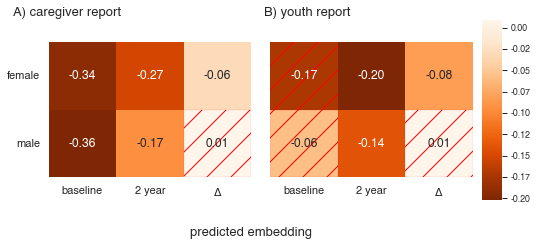

In [24]:
### create overarching list for plotting in heatmap 
caregiver_results = [fem_c, male_c]
youth_results = [fem_y, male_y]

## plot heatmap re: figure 2 in paper

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,5), sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.98, .25, .04, .5])

    
h1 = sns.heatmap(caregiver_results, 
            yticklabels= ["female", "male"], ax=ax[0],
           cbar_ax=cbar_ax, cmap="Oranges_r", annot=True, fmt=".2f", annot_kws={"fontsize":12},
           xticklabels= ["baseline", "2 year", r'$\Delta$'], square=True, 
                cbar_kws={"format":lambda x, _: f"{x:.2f}"})
ax[0].tick_params(left=False, bottom=False) ## other options are right and top


h1.set_yticklabels(h1.get_yticklabels(), rotation=0, fontsize=11) 
h1.set_xticklabels(h1.get_xticklabels(), fontsize=11) 


h2 =sns.heatmap(youth_results, 
            yticklabels= ["female", "male"], ax=ax[1],
           cbar_ax=cbar_ax, cmap="Oranges_r", annot=True, fmt=".2f", annot_kws={"fontsize":12},
           xticklabels= ["baseline", "2 year", r'$\Delta$'], square=True,
               cbar_kws={"format":lambda x, _: f"{x:.2f}"})
ax[1].tick_params(left=False, bottom=False) ## other options are right and top

h2.set_xticklabels(h1.get_xticklabels(), fontsize=11) 

plt.tight_layout(pad=2)

plt.figtext(0.05,0.76,"A) caregiver report",ha="left",size=13)
plt.figtext(0.72,0.76,"B) youth report",ha="right",size=13)
plt.figtext(0.4,0.15, "predicted embedding", size=13)



from matplotlib.patches import Rectangle
ax[0].add_patch(Rectangle((2, 1), 1, 1, fill=False, edgecolor='red', lw=0.1,
                         hatch="/")) #hightlights the non significant result
ax[1].add_patch(Rectangle((0, 0), 1, 1, fill=False, edgecolor='red', lw=0.1,
                         hatch="/")) 
ax[1].add_patch(Rectangle((0, 1), 1, 1, fill=False, edgecolor='red', lw=0.1,
                         hatch="/")) 
ax[1].add_patch(Rectangle((2, 1), 1, 1, fill=False, edgecolor='red', lw=0.1,
                         hatch="/")) 


#fig.savefig("ABCD_pubertal_associations.svg", bbox_inches='tight')

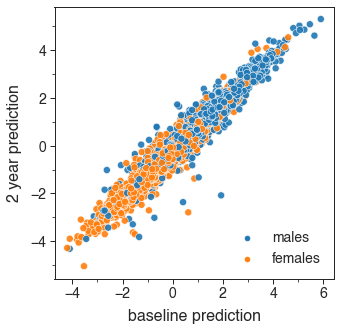

In [25]:
## plot figure 1b
import matplotlib.ticker as ticker


fig = plt.figure(figsize=(5,5))

scatter = sns.scatterplot(x= "prediction", y= "prediction_2y", data=embeddings, hue="sex", 
                 alpha=0.9, s=50, legend="full", hue_order=[1,0], palette="tab10")

scatter.set_xlabel('baseline prediction',fontsize=16, labelpad=8)
scatter.set_ylabel('2 year prediction',fontsize=16, labelpad=8)

handles, labels  =  scatter.get_legend_handles_labels()

scatter.legend(handles, ['males', 'females'], loc='lower right', frameon=False, fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=14)

scatter.xaxis.set_minor_locator(ticker.MultipleLocator(1))
scatter.yaxis.set_minor_locator(ticker.MultipleLocator(1))

#fig.savefig("ABCD_embeddings_sexStratify.svg", bbox_inches='tight')


In [26]:
### preparation for distribution visualization below

### merge 1y puberty and diff_emb

dist_visualization = pd.merge(embeddings[["diff_pred", "subjectkey", "sex",
                                 ]], 
            puberty_df_y[1][["PDS_category", "subjectkey"]], on="subjectkey")

dist_visualization.shape

(7636, 4)

/Users/Dominik/opt/anaconda3/envs/net_fusion/lib/python3.7/site-packages/seaborn/axisgrid.py:156: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  figlegend = self._figure.legend(handles, labels, **kwargs)


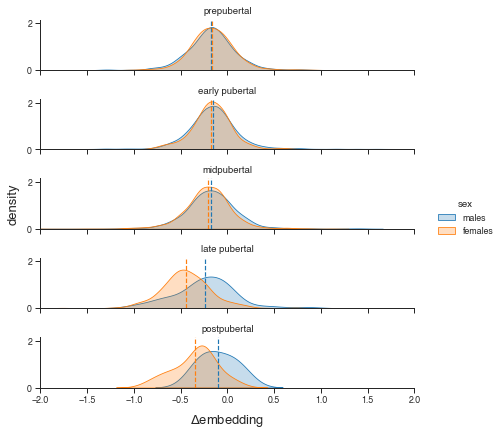

In [27]:
## plot figure 3 in paper

g = sns.FacetGrid(dist_visualization.dropna(subset=["PDS_category"]), row="PDS_category", 
                  row_order=["prepubertal", "early pubertal", "midpubertal",
                            "late pubertal", "postpubertal"],
                  height=1.2, aspect=5, hue="sex", legend_out=True, hue_order=[1,0],palette="tab10", xlim=(-2,2))
g.map(sns.kdeplot, "diff_pred", shade=True)

g.add_legend(labels=["males", "females"])


def vertical_mean_line(x, ax,  **kwargs):
    plt.axvline(x.mean(), linestyle ='--', color = kwargs.get("color", "blue"))

g.map(vertical_mean_line,'diff_pred', ax=ax)
    

g.set_xlabels(r'$\Delta$'+"embedding", fontsize=13, labelpad=8)

for i,ax in enumerate(g.axes.flat):
    if i != 2:
        ax.set_ylabel("")
    if i ==2:
        ax.set_ylabel('density', fontsize=13, labelpad=8)

for a in g.axes.flat:
    a.set_title(a.get_title()[15:])
    
    # hacky solution to exclude the vertical line for males in the last row, uncomment for caregiver plot
    
    #if a.get_title() == "postpubertal":
    #    for lines in a.lines:
    #        if lines.get_label() == "_child1":
    #            lines.set_visible(False)       
    
     
#g.savefig("delta_embedding_per_pubertalcat_caregiver_suppl.svg")